# Генеративные противобурствующие сети

В этой лабораторной работе ваша задача состоит в ознакомлении с GAN.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import preprocessing
import keras.layers
from keras.layers import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tqdm import tqdm
import os
import time
from tensorflow.keras import layers
import glob
import imageio
import PIL
from IPython import display

In [ ]:
# Для генерации GIF
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8ickkue3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-8ickkue3
  Resolved https://github.com/tensorflow/docs to commit c221d1e1af1ef5cc37c4a0879876f25f9cc1d981
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.11.18.43811-py3-none-any.whl size=182608 sha256=c6774104cbfb248925b86bfc4f419242f092e373e069368beedf174cb196b318
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ro0b3a0/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


#### Теория

**GAN**

Генеративные состязательные сети (Generative adversarial networks, GAN) - это алгоритмические архитектуры, которые используют две нейронные сети, противопоставляющие одну другой (таким образом, “состязательные”) для генерации новых синтетических экземпляров данных, которые могут сойти за реальные данные. Они широко используются при создании изображений, видео и голоса.

GAN состоит из двух компонентов:
- Генератор - генерирует новые данные.
- Дискриминатор - пытается отличить сгенерированные данные от реальных.

Генератор получает на вход шум (например, в виде случайного распределения) и генерирует поддельные изображения из шума.

Дискриминатор принимает изображение в качестве входных данных и выдает число, которое является вероятностью того, что входное изображение является реальным.

Интересным фактом здесь является то, что генератор учится создавать осмысленные изображения, даже не глядя на них.

В процессе обучения генератор постепенно совершенствуется в создании изображений, которые выглядят как настоящие, а дискриминатор - в их различении. Процесс достигает равновесия, когда дискриминатор больше не может отличать настоящие изображения от сгенерированных.




**Обучение и функции потерь**

Важным моментом в обучении GAN является то, что эти два компонента никогда не должны обучаться одновременно. Обучение сети происходит в два разных этапа: первый этап предназначен для обучения дискриминатора и корректировки весовых коэффициентов соответствующим образом, а на следующем этапе обучается генератор, в то время как обучение дискриминатора отключено.

Функции потерь должны быть разработаны так, чтобы позволять обучать генератор и дискриминатор состязательным образом. Поскольку эти две нейронные сети обучаются независимо, они должны быть обучены в два отдельных этапа. Для этого требуются две отдельные функции потерь, а также два отдельных обновления градиентов.

Когда для уменьшения потерь дискриминатора применяются градиенты дискриминатора, важно, чтобы обновлялись только веса дискриминатора. Нечестно и не принесет хороших результатов изменение весов генератора в пользу дискриминатора. Классическое обратное распространение сделало бы так: одновременно повлияло бы на веса как генератора, так и дискриминатора.

**Обучение дискриминатора**

Здесь генерируется обучающий набор с равным количеством реальных и поддельных изображений. Реальные изображения случайным образом отбираются из обучающих данных. Равное количество случайных изображений генерируется из случайного шума. Для обучающего набора дискриминатора `x` содержит входные изображения, а `y` содержит значение 1 для реальных изображений и 0 для сгенерированных.

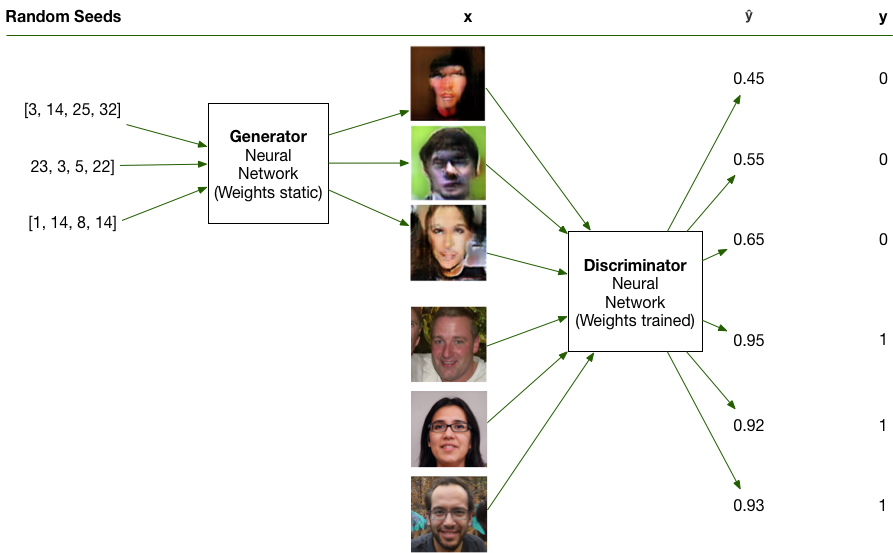

**Обучение генератора**

Для обучающего набора генератора `x` содержит случайный шум для генерации изображений, а `y` всегда содержит значение 1, потому что оптимальным является то, чтобы генератор сгенерировал такие хорошие изображения, что дискриминатор посчитал бы их за реальные и присвоил им вероятность, близкую к 1.

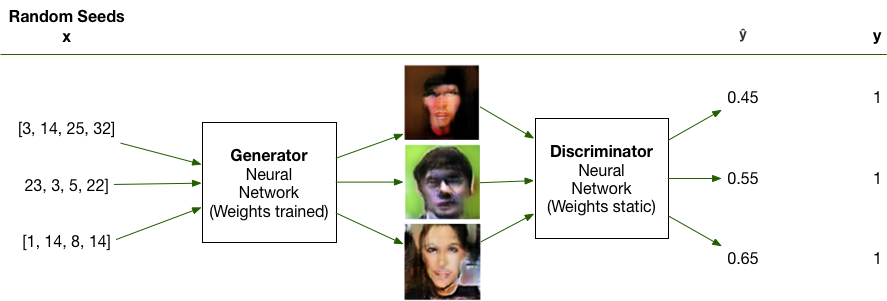

**Некоторые GAN**
- FCGAN (fully-connected GAN) - Простой GAN, в котором для генерации используются полносвязные слои и стандартные последовательные модели. Они не очень мощные;
- DCGAN (deep convolutional GAN) - Простой GAN, который предполагает использование сверточных слоев в GAN, и они гораздо эффективнее при создании изображений;
- Cycle GAN - Циклические GAN используются, когда необходимо взять изображение в качестве входных данных и преобразовать определенную его часть (например, если нужно преобразовать все яблоки на изображении в апельсины);
- Sytle GAN - разработан компанией NVIDIA для создания суперреалистичных лиц (а также автомобилей и спален);
- И многие другие.

**Полезные ссылки**
* Creating GANs From Scratch: https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/gans_scratch.ipynb
* Deep Convolutional Generative Adversarial Network: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb
* Introduction to GANs on Fashion MNIST Dataset: https://www.kaggle.com/code/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset#GAN-using-Deep-Convolutions
*  Introduction to GANs with Keras: https://www.kaggle.com/code/yushg123/introduction-to-gans-with-keras

## Отработка генеративной архитектуры

Первая задача - это простая отработка генеративной архитектуры. Необходимо, взяв за основу датасет https://www.kaggle.com/datasets/zalando-research/fashionmnist, получить на выходе сети подобные входным изображения. Архитектуру генератора и дискриминатора подбирайте самостоятельно.

In [ ]:
# Загрузка датасета Fashion MNIST
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

print(train_images.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)


In [ ]:
# Добавление размернности каналов к изображениям и нормализация данных
train_images = train_images.astype('float32') / 255.0
train_images = train_images*2 - 1
# После нормализации идёт умножение на 2 и вычитание 1 - так изображение находится в диапазоне от (-1,1),
# потому что в DCGANs последняя функция активации генератора - tanh, диапазон которого равен (-1,1), в отличие от сигмовидного диапазона (0,1).
train_images = np.expand_dims(train_images, axis=-1)
print(train_images.shape)

# alt:
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

(60000, 28, 28, 1)


In [ ]:
# Проверка диапазона изображений
print(train_images.max(),train_images.min())

1.0 -1.0


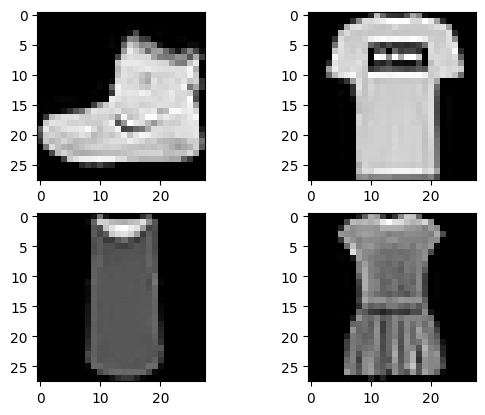

In [ ]:
# Визуализация первых 4х изображений
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(train_images[idx].reshape(28,28),cmap='gray')
        idx+=1

In [ ]:
# Параметры для перемешивания и разбивки на пакеты
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# TensorFlow Dataset используется для хранения изображений. Он позволяет быстро перемешивать данные и разбивать их на пакеты подходящего размера для обучения
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Функция создания модели генератора
# Генератор использует слои Conv2DTranspose для выработки изображения из начального шума
# Шум поступает на вход полносвязному слою, затем увеличивается несколько раз, пока не достигает желаемого размера изображения (28x28x1)
# Функция активации LeakyReLU используется для каждого слоя, за исключением выходного слоя, который использует tanh
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [ ]:
# Так выглядит шум, из которого генератор генерирует изображения
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 7.5252658e-01, -2.8780165e-01,  5.7725739e-01, -2.3274026e+00,
         7.1302786e-02, -7.1220636e-01, -1.4547635e+00, -2.9918644e-01,
         9.2752534e-01, -2.0949750e-01, -7.8823030e-01, -5.8855963e-01,
        -1.8358527e-01,  8.1065226e-01, -1.2451448e+00, -3.6237282e-01,
         1.5681119e+00, -1.5554029e-01,  1.0534170e+00, -8.1668384e-02,
         5.5172330e-01,  1.4700882e-01, -3.3234924e-01, -1.6594226e+00,
        -7.3736615e-02, -1.2011093e+00, -1.8804861e+00,  1.3928003e+00,
         4.6561331e-01,  1.6370929e+00,  1.0413111e+00,  1.6531852e+00,
         1.7095855e+00,  1.1982442e+00, -1.4542031e+00, -3.2508436e-01,
        -1.9165627e+00, -3.3662444e-01, -1.0462290e+00,  1.0297945e+00,
        -2.6116776e-01, -3.4993360e+00, -9.3061084e-01,  9.2150158e-01,
         2.0141325e+00,  2.2853646e+00,  1.2966695e+00, -7.6096410e-01,
         4.6857411e-01,  7.6092100e-01, -1.2653451e+00, -1.8047623e-01,
        -2.035

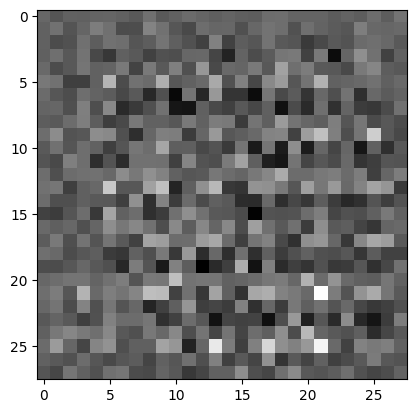

In [ ]:
# Создание модели генератора
generator = make_generator_model()

# Использование пока еще необученного генератора для создания изображения
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
# Функция создания модели дискриминатора
# Дискриминатор представляет собой классификатор изображений на базе CNN
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Создание модели дискриминатора
discriminator = make_discriminator_model()
# Использование пока еще не обученного дискриминатора, чтобы классифицировать сгенерированное изображение как настоящее или поддельное
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00130539]], shape=(1, 1), dtype=float32)


In [ ]:
# Этот метод возвращает вспомогательную функцию для вычисления потерь перекрестной энтропии
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Определение функций потерь для обеих моделей

# Этот метод количественно определяет, насколько хорошо дискриминатор способен отличать реальные изображения от подделок
# Он сравнивает предсказания дискриминатора для реальных изображений с массивом из единиц,
# а предсказания дискриминатора для поддельных (сгенерированных) изображений с массивом из 0
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Потери генератора определяют, насколько хорошо ему удалось обмануть дискриминатор
# Интуитивно понятно, что если генератор работает хорошо, дискриминатор классифицирует поддельные изображения как настоящие (или как 1)
# Здесь сравнивается решения дискриминатора по сгенерированным изображениям с массивом из единиц
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Определение оптимизаторов для обеих моделей, т.к. необходимо обучать две сети по отдельности
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Функция для генерации и сохранения изображения
# Будет использоваться по мере прохождения обучения для демонстрации прогресса
def generate_and_save_images(model, epoch, seed_noise):
    # Обучение модели отключено при этой генерации
    predictions = model(seed_noise, training=False)  # alt: generated_images = generator.predict(noise)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [ ]:
# Сохранение и восстанавление модели по чекпоинтам
# Может быть полезно в случае прерывания длительного обучения
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Параметры для обучения
EPOCHS = 50  # количество эпох
noise_dim = 100  # размер шума

# seed - Шум для генерации изображений в конце эпохи для демонстрации прогресса (используется в generate_and_save_images)
num_examples_to_generate = 16  # количество изображений, генерирумых для демонстрации прогресса
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Функция одного шага обучения
# Функция снабжена аннотацией tf.function, что обеспечивает предварительную компиляцию функции и повышает производительность
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    # Обучение начинается с того, что генератор получает случайный шум для создания изображения
    # Затем дискриминатор используется для классификации реальных (полученных из обучающего набора) и сгенерированных (созданных генератором) изображений
    # Потери рассчитываются для каждой из моделей, а градиенты используются для обновления генератора и дискриминатора

    # Здесь используется GradientTape, что позволяет обучать дискриминатор и генератор вместе и при этом по отдельности
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

In [ ]:
# Функция обучения модели
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Очищение вывода (экрана)
        display.clear_output(wait=True)
        # Генерация, вывод и сохранение изображения для демонстрации обучения
        generate_and_save_images(generator, epoch + 1, seed)

        # Сохранение модели в чекпоинт каждый 15 эпох
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print(f'Epoch {epoch + 1}, Time: {time.time() - start} sec')

    # Генерация после последней эпрхи
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

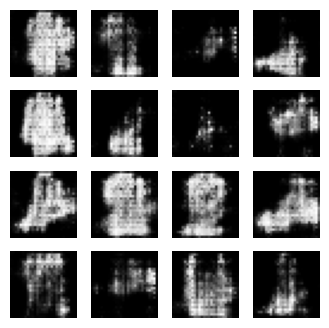

In [ ]:
# Обучение GAN
# Вызов train() для одновременного обучения генератора и дискриминатора
# Обучение GAN может быть сложным: важно, чтобы генератор и дискриминатор не слишком превосходили друг друга (например, чтобы они обучались с одинаковой скоростью)
train(train_dataset, EPOCHS)

In [ ]:
# Восстановление последнего чекпоинта
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Функция отображения конкретного изображения, используя номер эпохи
def display_image(epoch_no):
  return PIL.Image.open(f'image_at_epoch_{epoch_no:04d}.png')

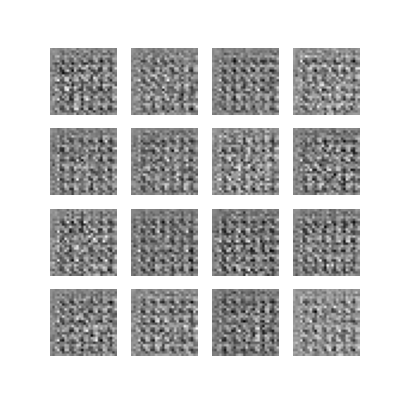

In [ ]:
# Отображение изображения первой эпохи
display_image(1)

In [ ]:
# Создание GIF, отображающую процесс обучения
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-33-1762b8c42ef4>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-33-1762b8c42ef4>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



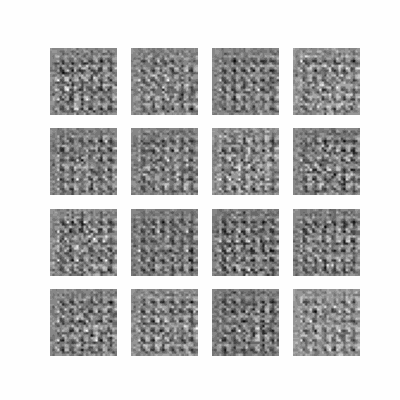

In [ ]:
# Вывод GIF
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Повышение качества изображения

Зачача №2 сосстоит в повышении качества изображения. Предлагается использовать две разные архитектуры: обычный автоэнкодер и генеративно-состязательную сеть. Здесь предлагается выбрать любой датасет, состоящий из изображений желательно в трех цветовых каналах, но можно взять и черно-белые, однако в любом случае исходные изображения должны быть в разрешении хотя бы 300х300 и представлять собой композиции (иначе говоря - быть "сложными". Подойдут, например, любые фотографии тех же кошек/собак). Датасет здесь состоит из изображений исходного размера, которые пойдут на выход, и их сжатых копий, которые пойдут на вход сети (просто скукожьте исходники с помощью resize в 2 или 4 раза). Отделите часть датасета для теста (не валидации!) и после обучения нейронной сети примените её к сжатым изображениям тестовой выборки. Результат применения выведете на экран. Не обязательно брать изображения в высоком разрешении,

### Загрузка и предобработка данных

In [ ]:
# Установка библиотеки opendatasets
! pip install opendatasets --upgrade

In [ ]:
# Импорт библиотек
import opendatasets as od
import os
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
# Загрузка датасета
od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: intergalactik
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog


100%|██████████| 218M/218M [00:03<00:00, 63.4MB/s]


In [ ]:
# Определение путей
train_directory = './cat-and-dog/training_set/training_set'
test_directory = './cat-and-dog/test_set/test_set'

In [ ]:
# Функция для создания сжатых изображений
def resize_images(train_dir, output_dir):
    # Итерация по директории
    for root, dirs, files in os.walk(train_dir):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                # Создание полного пути к изображению
                file_path = os.path.join(root, file)

                # Получение изображения
                image = cv2.imread(file_path)

                # Определение процента масштаба
                scale_percent = 12.5

                # Вычисление новых размеров
                h, w, _ = image.shape
                new_width = int(w * scale_percent / 100)
                new_height = int(h * scale_percent / 100)
                dim = (new_width, new_height)

                # Изменение размера изображения
                resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
                # resized = cv2.resize(image, (0,0), fx=0.5, fy=0.5)

                # Создание имени сжатого изображения
                original_file_name = os.path.splitext(file)[0]
                new_file_name = f"{original_file_name}.resized.jpg"
                new_file_path = os.path.join(output_dir, new_file_name)

                # Сохранение сжатого изображения
                cv2.imwrite(new_file_path, resized)

In [ ]:
import os
import cv2

# Создание сжатых копий для training_set/cats

# Директория с оригинальными изображениями
train_dir = './cat-and-dog/training_set/training_set/cats'
# Создание директории для сжатых изображений
output_dir = "./cat-and-dog/training_set_resized/cats"
os.makedirs(output_dir, exist_ok=True)
# Создание сжатых изображений
resize_images(train_dir, output_dir)

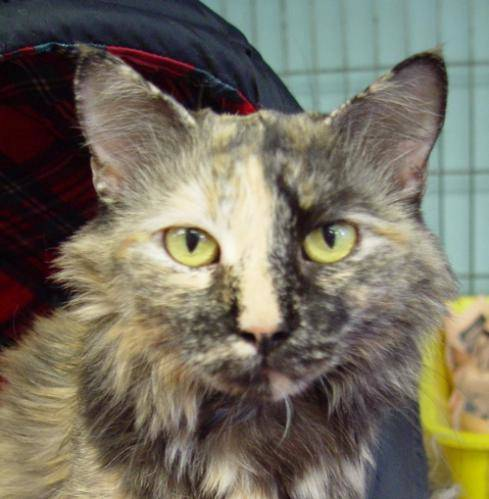

In [ ]:
# Отображение оригинала
PIL.Image.open("/content/cat-and-dog/training_set/training_set/cats/cat.10.jpg")

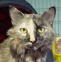

In [ ]:
# Отображение сжатой копии
PIL.Image.open("/content/cat-and-dog/training_set_resized/cats/cat.10.resized.jpg")

In [ ]:
# Создание сжатых копий для training_set/dogs

# Директория с оригинальными изображениями
train_dir = './cat-and-dog/training_set/training_set/dogs'
# Создание директории для сжатых изображений
output_dir = "./cat-and-dog/training_set_resized/dogs"
os.makedirs(output_dir, exist_ok=True)
# Создание сжатых изображений
resize_images(train_dir, output_dir)

In [ ]:
# Создание сжатых копий для test_set/dogs

# Директория с оригинальными изображениями
train_dir = './cat-and-dog/test_set/test_set/dogs'
# Создание директории для сжатых изображений
output_dir = "./cat-and-dog/test_set_resized/dogs"
os.makedirs(output_dir, exist_ok=True)
# Создание сжатых изображений
resize_images(train_dir, output_dir)

In [ ]:
# Создание сжатых копий для training_set/dogs

# Директория с оригинальными изображениями
train_dir = './cat-and-dog/test_set/test_set/cats'
# Создание директории для сжатых изображений
output_dir = "./cat-and-dog/test_set_resized/cats"
os.makedirs(output_dir, exist_ok=True)
# Создание сжатых изображений
resize_images(train_dir, output_dir)

In [ ]:
from pathlib import Path

# Функция для загрузки, изменения размера и нормализации изображений
def load_image(image_path, target_size=(128, 128)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0  # Нормализация в диапазон [0, 1]
    return img

# Функция для создания датасета
def create_dataset(input_dir, target_dir, target_size=(128, 128)):
    input_paths = sorted(list(input_dir.glob("*/*.jpg")))
    target_paths = sorted(list(target_dir.glob("*/*.jpg")))

    # Убеждаемся, что входные данные соответствуют таргету
    assert len(input_paths) == len(target_paths), "Mismatch between input and target images"

    # Создание датасета
    input_dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in input_paths])
    target_dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in target_paths])

    # Применение функции загрузи и обработки изображений
    input_dataset = input_dataset.map(lambda x: load_image(x, target_size), num_parallel_calls=tf.data.AUTOTUNE)
    target_dataset = target_dataset.map(lambda x: load_image(x, target_size), num_parallel_calls=tf.data.AUTOTUNE)

    # Соединение входных и выходных данных
    dataset = tf.data.Dataset.zip((input_dataset, target_dataset))

    # Перемешивание и разбивка на пакеты
    # TensorFlow Dataset используется для хранения изображений. Он позволяет быстро перемешивать данные и разбивать их на пакеты подходящего размера для обучения
    dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

# Пути к датасетам
input_dir = Path("cat-and-dog/training_set_resized")
target_dir = Path("cat-and-dog/training_set/training_set")
# Создание тренировочного датасета
train_dataset = create_dataset(input_dir, target_dir, target_size=(128, 128))

# Пути к датасетам
input_dir = Path("cat-and-dog/test_set_resized")
target_dir = Path("cat-and-dog/test_set/test_set")
# Создание тестового датасета
test_dataset = create_dataset(input_dir, target_dir, target_size=(128, 128))

# Проверка датасета
for inputs, targets in train_dataset.take(1):
    print("Input batch shape:", inputs.shape)
    print("Target batch shape:", targets.shape)

Input batch shape: (32, 128, 128, 3)
Target batch shape: (32, 128, 128, 3)


### Автоэнкодер

In [ ]:
from tensorflow.keras import layers, Model

# Функция для создания автоэнкодера
def build_autoencoder(input_shape=(128, 128, 3)):
    # Входной слой
    input_img = layers.Input(shape=input_shape)

    # Энкодер
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2))(x)  # Encoded representation

    # Декодер
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer

    # Автоэнкодер
    autoencoder = Model(inputs=input_img, outputs=decoded)
    return autoencoder

# Создание автоэнкодера
autoencoder = build_autoencoder()

# Компиляция модели
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Информация о модели
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Определение callback'ов - сохранение модели; остановка обучения модели
checkpoint = ModelCheckpoint("autoencoder_best.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Обучение модели
history = autoencoder.fit(
    train_dataset,
    epochs=20,
    validation_data=train_dataset,  # Optionally split a validation dataset if available
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 123ms/step - loss: 0.0271 - mae: 0.1187 - val_loss: 0.0083 - val_mae: 0.0641
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.0068 - mae: 0.0561 - val_loss: 0.0064 - val_mae: 0.0535
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.0059 - mae: 0.0513 - val_loss: 0.0063 - val_mae: 0.0537
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - loss: 0.0055 - mae: 0.0489 - val_loss: 0.0056 - val_mae: 0.0491
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 103ms/step - loss: 0.0052 - mae: 0.0474 - val_loss: 0.0054 - val_mae: 0.0489
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 0.0050 - mae: 0.0467 - val_loss: 0.0052 - val_mae: 0.0474
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - loss: 0.0048 - mae: 0.0447 - val_loss: 0.0052 - val_mae: 0.0478
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 0.0046 - mae: 0.0444 - val_loss: 0.0049 - val_mae: 0.0459
Epoch 9/20
251/251 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


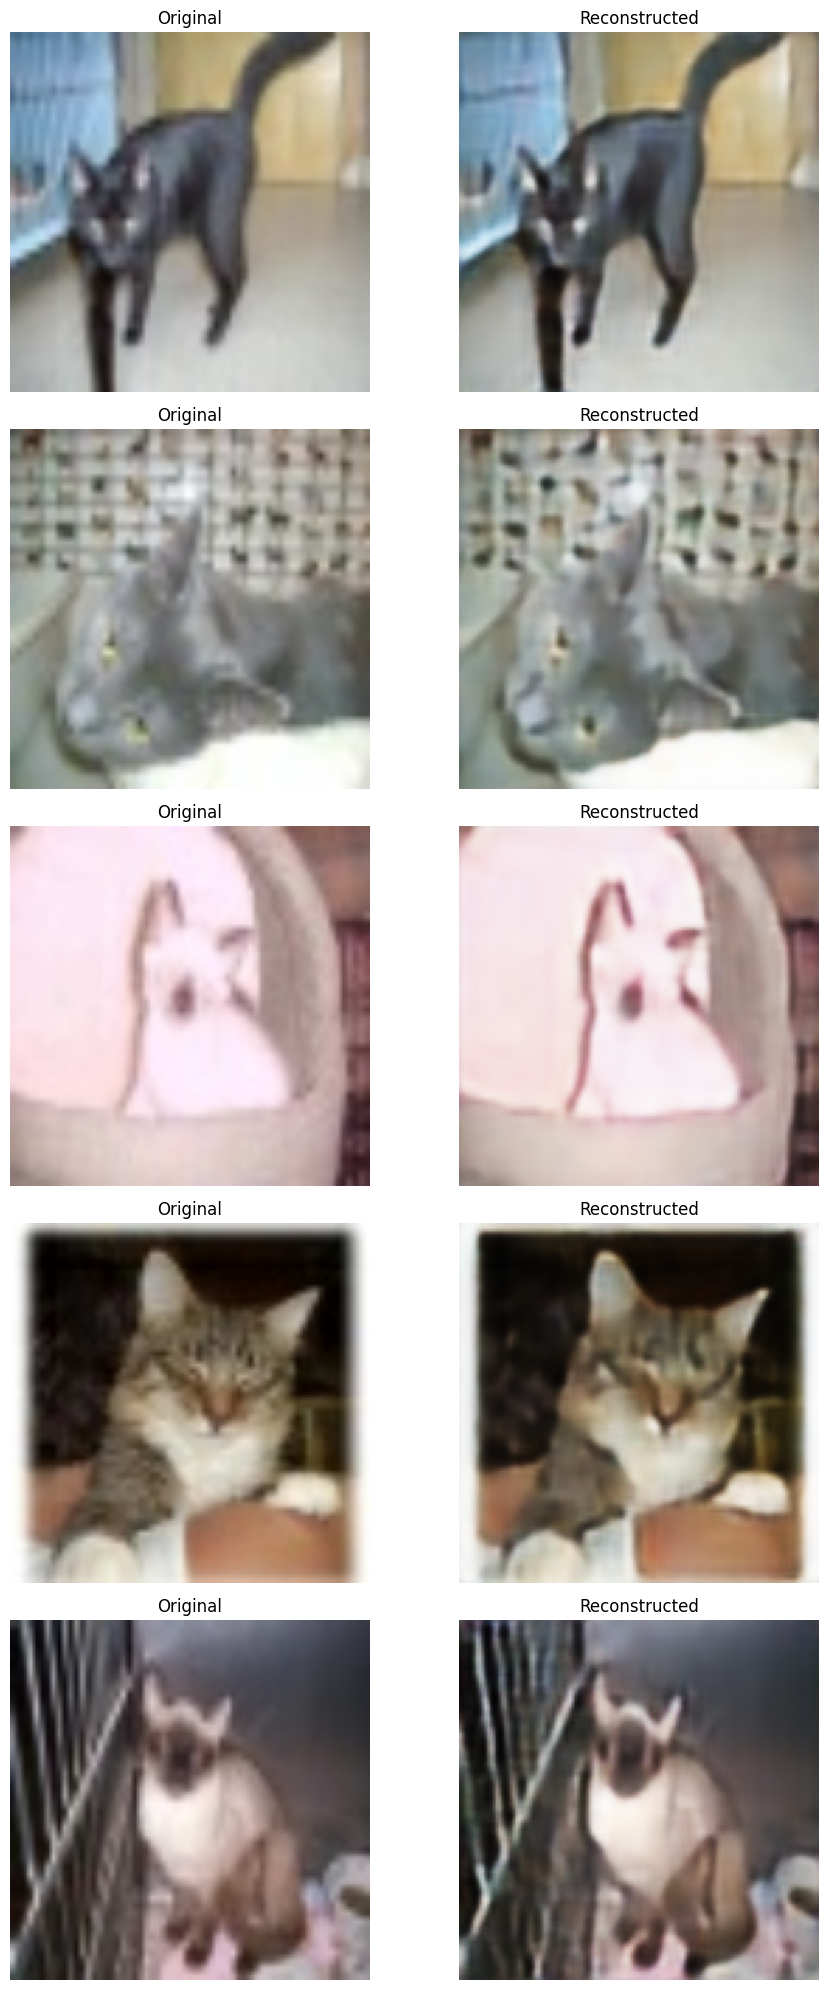

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


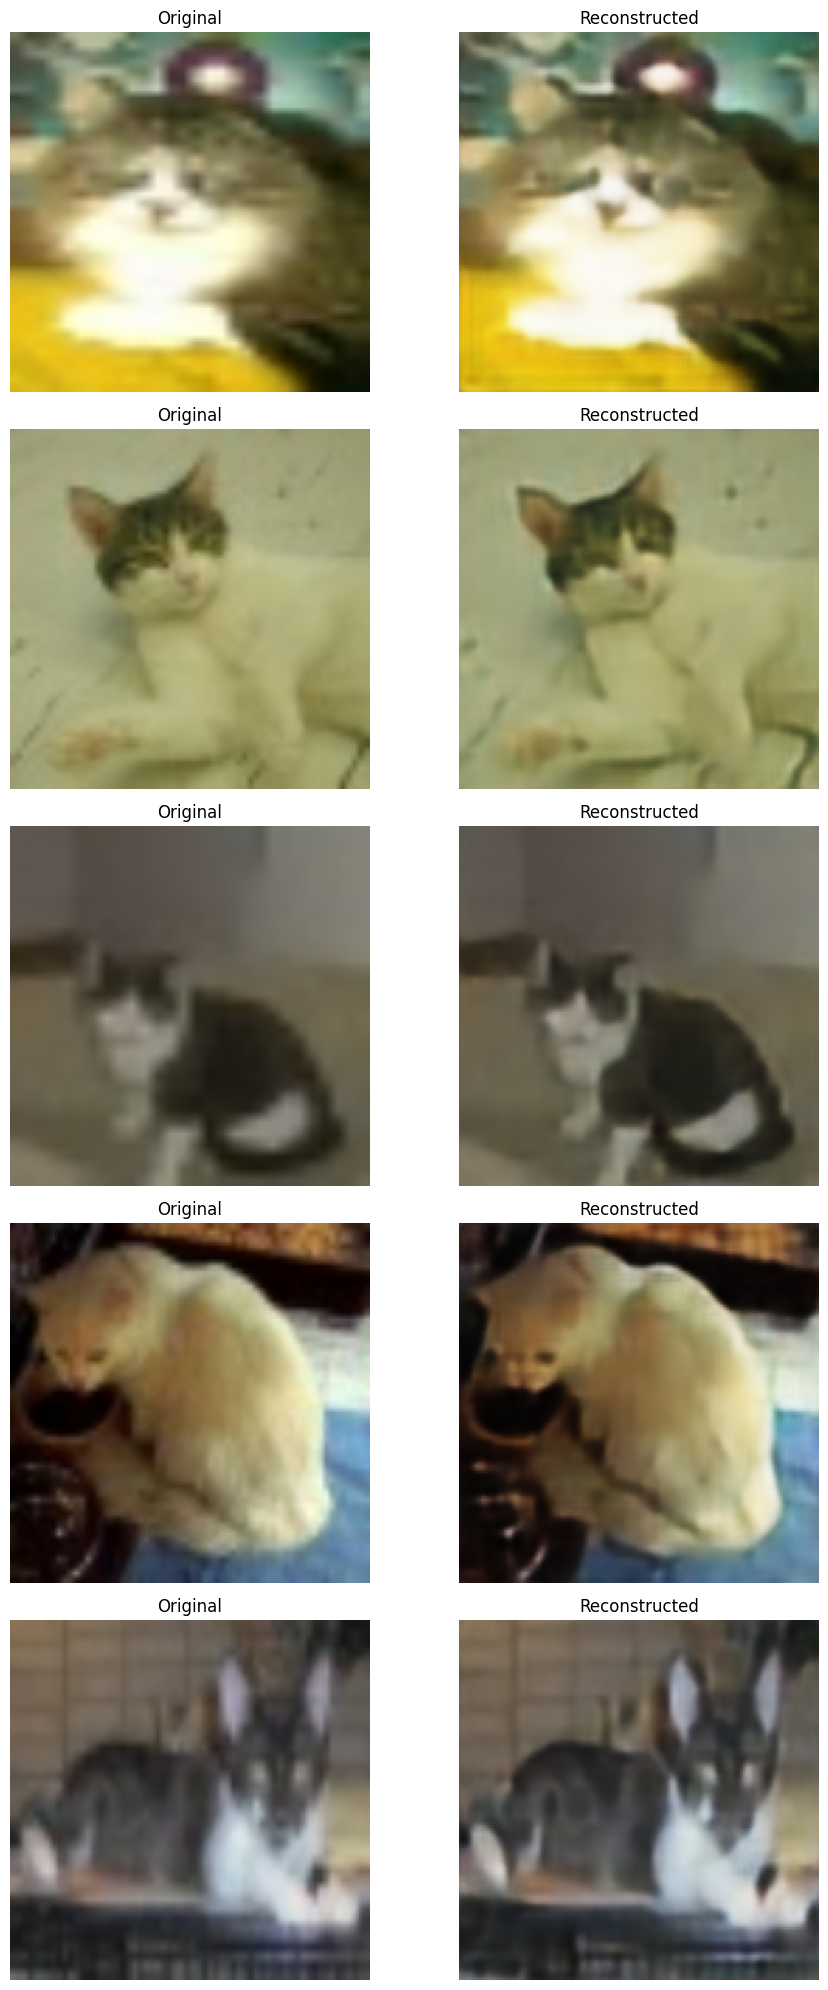

In [ ]:
# Функция для отображения оригинальных и восстановленных изображений
def display_images(inputs, outputs, num_images=5):
    plt.figure(figsize=(10, 4 * num_images))
    for i in range(num_images):
        # Оригинальное
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(inputs[i])
        plt.title("Original")
        plt.axis("off")

        # Восстановленное
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(outputs[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Применение модели к тестовым данным
# Получение пакетов из тестового датасета
for inputs, targets in test_dataset.take(2):
    # Генерация восстановленных изображений
    reconstructions = autoencoder.predict(inputs)

    # Отображение изображений
    display_images(inputs, reconstructions, num_images=5)

### GAN

In [ ]:
# Функция для создания модели генератора
def build_generator(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Уменьшение размерности
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Увеличение размерности
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Выходной слой
    outputs = layers.Conv2D(3, kernel_size=4, strides=1, padding="same", activation="sigmoid")(x)

    return tf.keras.Model(inputs, outputs)

# Функция для создания модели дискриминатора
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# Класс модели GAN, наследует от tf.keras.Model
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    # Метод компиляции модели
    def compile(self, g_optimizer, d_optimizer, loss_fn, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    # Тренировочный шаг
    def train_step(self, data):
        input_images, target_images = data

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Генерация изображений
            generated_images = self.generator(input_images, training=True)

            # Результат (вывод) дискриминатора для реальных и сгененрированных изображений
            real_output = self.discriminator(target_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Вычисление функций потерь
            gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)
            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = real_loss + fake_loss

        # Вычисление градиентов
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        # Применение градиентов
        self.g_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        # Возврат значений функций потерь для их вывода на экран
        return {"gen_loss": gen_loss, "disc_loss": disc_loss}

In [ ]:
# Создание моделей генератора и дискриминатора
generator = build_generator()
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# Создание GAN
gan = GAN(generator, discriminator)
# Компиляция GAN
gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
# Обучение GAN
history = gan.fit(train_dataset, epochs=25)

Epoch 1/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 92s 258ms/step - disc_loss: 1.4173 - gen_loss: 1.1728
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 212ms/step - disc_loss: 1.3729 - gen_loss: 1.0606
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 210ms/step - disc_loss: 1.4188 - gen_loss: 0.8872
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - disc_loss: 1.3291 - gen_loss: 1.1648
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 210ms/step - disc_loss: 1.3337 - gen_loss: 1.0978
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 214ms/step - disc_loss: 1.2476 - gen_loss: 1.2152
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 209ms/step - disc_loss: 1.2817 - gen_loss: 1.1285
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 214ms/step - disc_loss: 1.2359 - gen_loss: 1.1697
Epoch 9/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 213ms/step - disc_loss: 1.2222 - gen_loss: 1.2200
Epoch 10/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 213ms/step - disc_loss: 1.1353 - gen_loss: 1.3330
Epoch 11/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 209ms/step - d

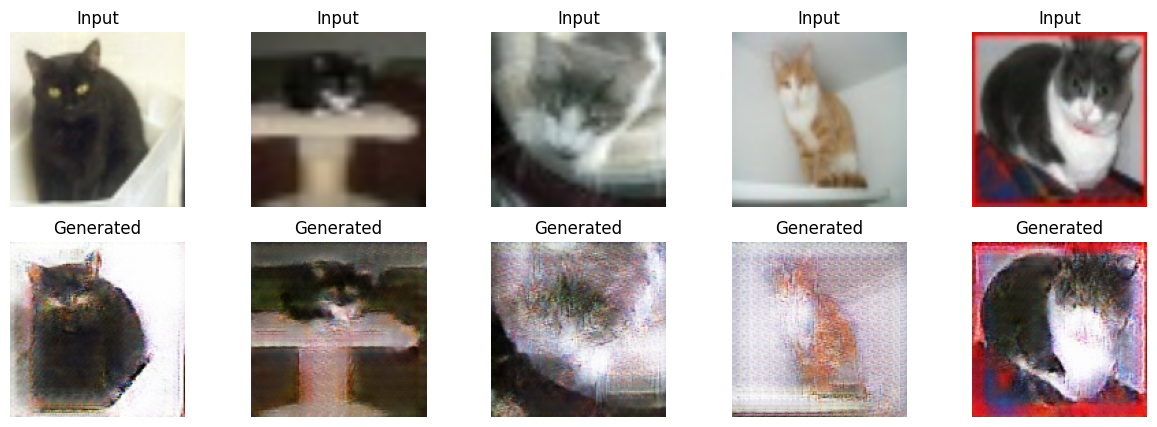

In [ ]:
# Функция для отображения оригинальных и восстановленных изображений
def generate_and_plot_images(generator, dataset, num_images=5):
    # Получение пакетов из датасета
    for input_images, target_images in dataset.take(1):
        # Генерация восстановленных изображений
        generated_images = generator(input_images, training=False)

        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            # Оригинальное
            plt.subplot(2, num_images, i + 1)
            plt.imshow(input_images[i].numpy())
            plt.title("Input")
            plt.axis("off")

            # Восстановленное
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(generated_images[i].numpy())
            plt.title("Generated")
            plt.axis("off")
        plt.show()

# Применение модели к тестовым данным и отображение изображений
generate_and_plot_images(generator, test_dataset)

### ESRGAN

ESRGAN (Enhanced Super-Resolution GAN) - это улучшенная версия модели SRGAN (Super-Resolution GAN), которая используется для повышения разрешения изображений. ESRGAN была разработана для создания более качественных и детализированных изображений с высоким разрешением на основе изображений с низким разрешением.

Здесь используется уже обученная модель ESRGAN: https://www.kaggle.com/models/kaggle/esrgan-tf2/tensorFlow2/esrgan-tf2/1

In [ ]:
# Функция для предобработки изображения, чтобы оно могло быть обработано моделью
def preprocess_image(image_path):
    '''
    Загружает заданное изображение, подготавливая его к использованию в модели
        Аргументы:
            image_path: Путь к файлу изображения
    '''
    image = tf.image.decode_image(tf.io.read_file(image_path))
    if image.shape[-1] == 4:
        image = image[...,:-1]
    size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
    image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
    image = tf.cast(image,tf.float32)
    return tf.expand_dims(image,0)

In [ ]:
# Путь к изображению
IMAGE_PATH = '/content/cat-and-dog/test_set_resized/cats/cat.4003.resized.jpg'

In [ ]:
#%matplotlib inline
def plot_image(image,title=''):
    '''
    Строит график изображения (выводит изображение на экран)
    Аргументы:
        image: Тензор 3D изображения
        title: Заголовок для графика
    '''
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

In [ ]:
# Загрузка предобученной модели
import tensorflow_hub as hub
model = hub.load("https://www.kaggle.com/models/kaggle/esrgan-tf2/TensorFlow2/esrgan-tf2/1")

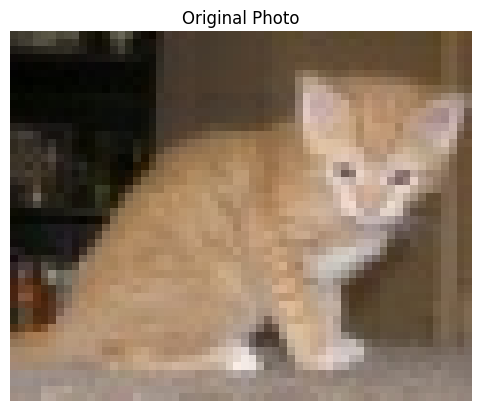

In [ ]:
# Предобработка изображения
load_image = preprocess_image(IMAGE_PATH)

# Отображение исходного изображения
plot_image(tf.squeeze(load_image),title='Original Photo')

In [ ]:
# Применение модели к изображению
start = time.time()
super_image = model(load_image)
super_image = tf.squeeze(super_image)
print('Time taken to complete process: %f'%(time.time() - start))

Time taken to complete process: 0.017741


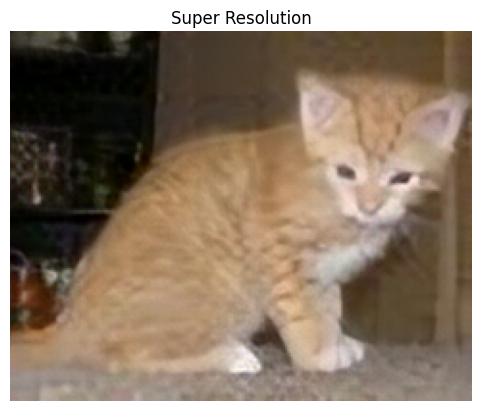

In [ ]:
# Отображения результата работы модели (сгенерированного изображения)
plot_image(tf.squeeze(super_image),'Super Resolution')